# Imports and Reading in Data

In [ ]:
!pip install -U fastai

     |████████████████████████████████| 189 kB 5.0 MB/s 
     |████████████████████████████████| 56 kB 2.4 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
from fastai.text.all import *
import pandas as pd
import seaborn as sns
%matplotlib inline

In [ ]:
reviews = pd.read_csv("reviews.csv", index_col=0)
reviews.sample(5)

,book_title,review_text,num_likes,star_rating
26328,The Christmas Day Kitten,"A really lovely, sweet and true story for Christmas time. This book was written by a vet and this was a real story from his life as a vet.There once was a woman called Mrs. Pickering who had three basset hounds she loved, and a little cat visitor she called Debbie who would stop by to eat at her house and visit the fire, but never stayed, she would come inside for a while and then disappear for days. One Christmas day the little cat shows up very ill and the vet (James Herriot) is called in, Debbie came through the cold snow with her baby kitten knowing she was dying, so she could leave he...",2,5.0
2664,The Winter of the Witch,"While the plot line was sometimes lost on me, the writing in this trilogy is beautiful. There were arcs in this story that almost made it feel like I was reading two separate books instead of a single cohesive one. While I enjoyed what happened in The Winter of the Witch, this was not my favorite in the series. I adored (most of) the characters in The Winternight Trilogy. Vasya is a fantastic protagonist and I was sad to reach the last page of her story.",74,4.0
47394,Complete Me,"*ARC courtesy of Random House, provided by Netgalley in exchange for an honest review* ""You're my reality."" ""And you're mine."" What a perfect ending to a great series!!It was a sexy,emotionally charged romance!This was also more intense and had me on edge throughout!!Their story takes a lot of twists...Damien and Nikki have a lot more issues with outside people through this book and at times your not really sure who to trust....Damien refuses to share his abuse past and vows to keep information that could sway the court hidden..His past continues to haunt him more than ever..Nikki continu...",55,4.0
12799,Saga #54,I just had to do a quick reread of this single issue. It’s so freaking good and my heart is broken. I love this series.,3,5.0
23081,On Writing: A Memoir of the Craft,"On Writing: A Memoir of the Craft offers an illuminating look at Stephen King's life, highlighting moments that shaped him as an author and revealing lessons he gained from decades of practice and publication. King is unapologetically himself, blending whit and honesty with sophomoric humor and the occasional curse word. For example, when discussing the sin of using passive voice, King provides an example of how not to construct a sentence, followed by the type of commentary one can expect to find throughout his book: How about this: My first kiss will always be recalled by me as how my ro...",83,5.0


In [ ]:
books = pd.read_csv("books.csv", index_col=0)
books.sample(5)

,book_title,author,url,avg_rating,num_ratings,num_reviews
592,Killing the Rising Sun: How America Vanquished World War II Japan,Bill O'Reilly,https://www.goodreads.com/book/show/29370481-killing-the-rising-sun,4.34,16819,1701
2341,برهان العسل,سلوى النعيمي,https://www.goodreads.com/book/show/6014609,2.63,2193,455
1244,Other-Wordly: Words Both Strange and Lovely from Around the World,Yee-Lum Mak,https://www.goodreads.com/book/show/28665384-other-wordly,4.27,1469,351
2442,The Worst Noel: Hellish Holiday Tales,Cynthia Kaplan,https://www.goodreads.com/book/show/1359702.The_Worst_Noel,2.64,284,64
1379,Snuff,Terry Pratchett,https://www.goodreads.com/book/show/8785374-snuff,4.11,57228,2894


***
# EDA and Data Cleaning

## NaN Reviews

In [ ]:
reviews.shape

(82637, 4)

In [ ]:
# remove NaNs
# why are there NaN's?

reviews[reviews["review_text"].isna()].groupby("book_title").size()

book_title
40: A Doonesbury Retrospective                                                      2
99 Percent Perspiration: A Frazz Collection                                        19
A Life of Crime                                                                    13
A Practical Way to Get Rich . . . and Die Trying: A Memoir about Risking It All    17
A Very Private Life                                                                 6
                                                                                   ..
تفسير التحرير والتنوير                                                             22
حكايات الجواري في قصور الخلافة                                                      4
وحي القلم                                                                          30
宝石の国 7 [Houseki no Kuni 7]                                                          4
宝石の国 8 [Houseki no Kuni 8]                                                         10
Length: 241, dtype: int64

In [ ]:
reviews[reviews["review_text"].isna()].sample(5)

,book_title,review_text,num_likes,star_rating
78281,Wit zand,NaN,0,3.0
13332,Blazing Splendor: The Memoirs of Tulku Urgyen Rinpoche,NaN,0,4.0
60619,Secrets of Saffron: The Vagabond Life of the World's Most Seductive Spice,NaN,0,2.0
59630,KRAZY!: The Delirious World of Anime + Comics + Video Games + Art,NaN,0,4.0
60997,The Hunger,NaN,0,4.0


In [ ]:
reviews = reviews[~reviews["review_text"].isna()]

In [ ]:
reviews.shape

(78932, 4)

## Reviews in Different Languages

Source: https://towardsdatascience.com/4-python-libraries-to-detect-english-and-non-english-language-c82ad3efd430 

In [ ]:
!pip install spacy_langdetect

     |████████████████████████████████| 998 kB 6.2 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-py3-none-any.whl size=993430 sha256=cc40c6728f8eb0cc2e35d89a0c18a588cabecd9586c1a24a092a532f6e23d21c
  Stored in directory: /root/.cache/pip/wheels/89/79/3b/9885ae7f4308f73c514f96d8574d40d7d8173a27731b674013
Successfully built langdetect


In [ ]:
from spacy_langdetect import LanguageDetector  
import spacy  

In [ ]:
nlp_eng = spacy.load('en')
nlp_eng.add_pipe(LanguageDetector(), name='language_detector', last=True)

In [ ]:
# text_content = "Er lebt mit seinen Eltern und seiner Schwester in Berlin."  
# doc = nlp_eng(text_content) #3  
# detect_language = doc._.language #4  
# print(detect_language)  
# {'language': 'de', 'score': 0.9999958526911192}

In [ ]:
lang_preds = reviews["review_text"].apply(lambda x: list(nlp_eng(x)._.language.values()))

In [ ]:
lang_preds.to_csv("lang_preds.csv", header=True)

In [ ]:
lang_preds

0        [en, 0.9999982790290753]
1        [en, 0.9999947452241519]
2        [en, 0.9999964215895704]
3        [en, 0.9999968755576859]
4        [en, 0.9999958060506386]
                   ...           
82632    [en, 0.9999950442092785]
82633    [en, 0.9999984350796891]
82634    [en, 0.9999960570631923]
82635    [en, 0.9999961131706421]
82636    [en, 0.9999971229592783]
Name: review_text, Length: 78932, dtype: object

In [ ]:
lang_preds = pd.read_csv("lang_preds.csv", index_col=0)
lang_preds.sample(5)

,review_text
79432,"['en', 0.9999974650247516]"
34889,"['en', 0.9999964034906637]"
68154,"['en', 0.9999964778296642]"
32299,"['en', 0.999998175735434]"
30820,"['en', 0.9999995320792743]"


In [ ]:
first = lang_preds["review_text"][0]
first

"['en', 0.9999982790290753]"

In [ ]:
first[first.index(",")+2:-1]

'0.9999982790290753'

In [ ]:
first[2:first.index(",")-1]

'en'

In [ ]:
reviews["pred_lang"] = lang_preds["review_text"].apply(lambda x: x[2:x.index(",")-1])
reviews["pred_conf"] = lang_preds["review_text"].apply(lambda x: float(x[x.index(",")+2:-1]))

In [ ]:
reviews[["pred_lang", "pred_conf"]]

,pred_lang,pred_conf
0,en,0.999998
1,en,0.999995
2,en,0.999996
3,en,0.999997
4,en,0.999996
...,...,...
82632,en,0.999995
82633,en,0.999998
82634,en,0.999996
82635,en,0.999996


In [ ]:
reviews[(reviews["pred_conf"] < .99) & (reviews["pred_lang"] == "en")].sort_values("pred_conf").sample(20)

,book_title,review_text,num_likes,star_rating,pred_lang,pred_conf
6843,Heartstopper: Volume Two,1.) Heartstopper Volume 1 ★★★★★2.) Heartstopper Volume 2 ★★★★★3.) Heartstopper Volume 3 ★★★★★------------------------------------------------I LOVE THESE BOOKS SO GODDAMN MUCH 😭,151,5.0,en,0.714284
26638,The Negotiator,"""Control the situation; don't let it control you.""",3,3.0,en,0.571427
15988,The Complete Sherlock Holmes,I'm a fantasy girl. I never liked detective stories. Until I got Sherlocked.,69,5.0,en,0.857139
48314,Tower of Dawn,Love Chaol's character development.👏🏼,178,5.0,en,0.571427
7098,Dog Man and Cat Kid,Big fans of Cat Kid over here!,2,4.0,en,0.857142
10950,"Cutting Right to the Chase Vol.2, (Chase Williams detective short stories 2)","Scroll down for the English version.Altri dieci casi taglienti per ChaseContinua l’esperimento letterario di Stefania Mattana che, dopo la prima raccolta con sei racconti di mille parole incentrati sulla figura dell’ex-investigatore di Scotland Yard trapiantato in Italia, torna con altri dieci piccoli casi, che scavano più a fondo nella personalità del protagonista e nell’ambientazione di Tursenia, restituendoci un’immagine complessa, capace a tratti di divertire, commuovere e far rabbrividire.Alternando storie leggere, quasi frivole, con altre ben più impegnative, fino a diventare quasi c...",7,5.0,en,0.571429
43168,Entwined with You,"Español - EnglishEva, si eso es posible, adora más a Gideon por el sacrificio que hizo por ella, pero la desconciertan las actuaciones de Gideon sin contar con su aprobación. Aun así está segura que no puede vivir sin él y ella para Gideon es el aire que respira.---Eva, if that's possible, loves Gideon even more for the sacrifice he made for her, but she is disconcert with Gideon's actions without her approval. Yet she is certain that she can not live without him and she represents to Gideon the air he breathes.",109,5.0,en,0.857142
32807,Guards! Guards!,"Guards! Guards! (Discworld, #8; City Watch #1), Terry PratchettGuards! Guards! is the eighth Discworld novel - and after this, dragons will never be the same again! The story follows a plot by a secret brotherhood, the Unique and Supreme Lodge of the Elucidated Brethren of the Ebon Night, to overthrow the Patrician of Ankh-Morpork and install a puppet king, under the control of the Supreme Grand Master. Using a stolen magic book, they summon a dragon to strike fear into the people of Ankh-Morpork.Once a suitable state of terror and panic has been created, the Supreme Grand Master proposes ...",50,4.0,en,0.857140
35843,Pierre: A Cautionary Tale in Five Chapters and a Prologue,Fantastic! Breathtaking! Original!,3,5.0,en,0.857140
30780,Rebecca,"English (Rebecca) / Italiano«Last night I dreamt I went to Manderley again»Manderley, an estate located in southern England, is the absolute protagonist of this novel. Owned by the rich widower Maxim De Winter, it is a place known across England, especially thanks to his first wife Rebecca, now deceased. During her married life, in fact, Rebecca turned Manderly into a center of social life and entertainment. A place on everyone's lips.But now Rebecca is gone, died in a shipwreck, and this tragic passing contributed to turn her into a celestial figure, invaluable in the eyes of the people w...",206,4.0,en,0.714284


Most low confidence 'en'-labeled reviews are actually English. The ones that aren't will all have low frequency words, so they won't be in the embedding matrix.

In [ ]:
reviews[reviews["pred_lang"] != "en"].sort_values("pred_conf").sample(20)

,book_title,review_text,num_likes,star_rating,pred_lang,pred_conf
1146,العصبي,"ثاني قراءة للكاتب بعد انتحار فاشلالقصص ساخرة من الدرجة الأولى، موجعة للغاية أحياناًأحمد رمضان يمزج بين السخريه والنقد والألم بطريقه سحريه، ويقدم نموذج ساخر شديد الواقعية، دون رتوش أو تكلف، لسلبيات مجتمع حافل بالتناقضات التى تثير الضحك أحياناً، والألم أحياناً أخرىمجتمع يحلم أفراده دوماً بالبطولة، لكنه يهرب من أي مسؤلية مهما كانت بسيطة فى الواقع كما فى قصة البطل ""أو يفقد فيه أى شخص هدوء أعصابه في النهاية تحت وطأة الضغوط غير المعتادة التي يتعرض لها كما في قصة العصبي ورغم أن نهايات بعض القصص موجعة كما فى قصة "" معلش""، لكنها أيضاً مغلفة بظل من السخرية السوداء تكشف مدى جهلنا كأفراد عن قدراتنا على...",25,5.0,ar,0.999998
63583,El planeta americano,Muy interesante me lo leí en ética,0,3.0,es,0.999996
15523,East of Eden,So FANTASTIC!!!!!!!!!!!!!!!!,112,5.0,so,0.428572
75582,Vissen redden,grappig vreemd,0,5.0,af,0.999994
70417,The World Rose,People like him make me hate people in general. -________-,26,1.0,af,0.857138
16586,The Little Prince,"(Book 574 from 1001 Books) - Le Petit Prince = The Little Prince, Antoine de Saint-ExupéryThe Little Prince, first published in 1943, is a novella, the most famous work of French aristocrat, writer, poet, and pioneering aviator Antoine de Saint-Exupéry. The Little Prince is a poetic tale, with watercolor illustrations by the author, in which a pilot stranded in the desert meets a young prince visiting Earth from a tiny asteroid. The story is philosophical and includes social criticism of the adult world. It was written during a period when Saint-Expiry fled to North America subsequent to t...",482,5.0,fa,0.999999
5408,El guerrero a la sombra del cerezo,"Una novela magistral.Narra las aventuras de un joven guerrero en el Japón feudal del siglo XVIII. La cultura, la guerra, el amor y la intriga forman al perfecto samurai.Me ha resultado una lectura buenísima y lo he disfrutado muchísimo. Una gran sorpresa.",32,5.0,es,0.999995
77669,الطلياني,"لقد هجرت الادب التونسي منذ 17سنة ،لكن حين رأيت هذه الرواية ،شدني الفضول و الحنين للقراءة شئ قريب مني جغرافيا، خاصة أنه يتحدث على فترة دائما ما تحدث عنها اقاربي- سنوات بورقيبة الاخيرة قبل الإنقلاب- و كان نقاش بينهم يحتد حول دور الإسلاميين و اليساريين و الدستورين في تلك الفترة.لقد اقبلت على هذه رواية بمعنويات جيدة خاصة انها تحصلت على جائزة البوكر.لكن و بعد الصفحات الأولى بدأت احس بالإمتعاض كيف يقدم"" عبد الناصر"" على ضرب الإمام في جنازة أبيه الحاج ""محمود"" لكنني أردت المواصلة عسى أفهم لم أطلق عليه الطلياني -سمي هكذا للحسنه و شبهه بالإيطاليين.-الرواية عبارة عن سيرة ذاتية لعبد الناصر لكن على لسان...",35,1.0,ar,0.999999
7341,1001 Inventions: Muslim Heritage in Our World,DNF so sorry,0,3.0,sv,0.999994
40144,A People's History of the United States,"A People's History of the United States, Howard ZinnHoward Zinn (Born: August 24, 1922, New York, New York, United States, Died: January 27, 2010, Santa Monica, California, United States) was an American historian, playwright, philosopher, socialist thinker and World War II veteran. He was chair of the history and social sciences department at Spelman College, and a political science professor at Boston University.A People's History of the United States has been chronicling American history from the bottom up, throwing out the official version of history taught in schools -- with its empha...",59,4.0,fa,0.999999


The false negatives here (actually English but labeled something else) are just one or two words.

In [ ]:
reviews_eng = reviews[reviews["pred_lang"] == "en"]
reviews_eng.sample(5)

,book_title,review_text,num_likes,star_rating,pred_lang,pred_conf
36742,"The Disaster Artist: My Life Inside The Room, the Greatest Bad Movie Ever Made","I read this account of the Best Worst Movie Ever Made after seeing the film. I loved the movie in December and I savored every word of Greg Sestero and Tom Bissell's story just as much. It was at once weirdly touching and laugh-out-loud funny. And, of course, I heard in my head the incredible voice of Tommy Wiseau every time the man with the (forgive me) vision spoke.",19,5.0,en,0.999997
5585,Black and British: A Forgotten History,"Just as a heads up - I've decided not to rate books I'm reading as part of my own educational development in racial history and social policy etc. This was an incredibly well thought out and researched book into an area of British history that has been largely overlooked, forgotten or erased. It follows to lives of Black British individuals chronologically through time from the Roman era, to the Georgian and Victorian, World War and beyond. I found it fascinating to see how the intricacies of slavery abolition and emancipation lead to wider repurcussions in the British empire. For example,...",25,NaN,en,0.999997
52439,Burning Chrome,"Wired West""Burning Chrome"" is a fascinating collection of stories that chart the origin of the Sprawl Trilogy. You can watch William Gibson building the world of the Sprawl (""of cities and smoke""), cyberspace and the characters who would later be explored in the three novels.Equally importantly, you can observe him developing a unique style of writing suited to this world.It's data- and sensory-rich, almost exhausting in its detail, which is revealed without information dumps or definitions. It assumes that we're keeping up with the story and we get it, without having to have things explai...",16,4.0,en,0.999997
58840,The Wicked Heart,"One of the best I’ve read from Christopher Pike! And that’s saying something considering I adore his work! Plenty of suspense that kept me on edge, waiting for what will happen. Spoilers: The ending was very sad, I liked Dusty, I was hoping he would get some help. I felt like crying when he died and I don’t ever cry over books. I really felt for the protagonist.",0,5.0,en,0.999996
68217,Behind the Bell,This is the life I have chosen for myself.,22,1.0,en,0.999997


In [ ]:
reviews_eng[reviews_eng["pred_conf"] < .6].sort_values("pred_conf", ascending=True)

,book_title,review_text,num_likes,star_rating,pred_lang,pred_conf
32325,"The Walking Dead, Vol. 1: Days Gone Bye",Ohhhhhhhhhh Yeah- I'm hooked!,40,5.0,en,0.285715
74251,Pixu: The Mark of Evil,Short. Strange. Gripping.,1,4.0,en,0.428554
80763,گندم,"khob yek romane iranie javan pasande!! koliate dastan jazabe , shayad be in dalil ke be zamane ma nazdike vali be e'eteghade man arzeshe ghalame nevisande paine , dar vaghe ketab yek seriale televizionie maktube. baraye onaei ke shifteye majerahaye eshghi hastan pishnahadesh mikonam albate in dastan hame chiz dare : e'etiad , faghr , fesade akhlaghi , takhribe fazaye sabz , aparteman sazi! , talaghe valedein , nakamie javani dar eshgh , bacheye sare rahi , faghat chon in dastane marbut be chand sale pishe , nevisande be khatere adame gostareshe ghorshaye shadi avar in mowzu ro az ghalame s...",2,1.0,en,0.428571
81984,Batman: Haunted Gotham,Wrote me review here - http://www.thegothamarchives.com/revi...,0,2.0,en,0.428571
2280,"Transmetropolitan, Vol. 10: One More Time","When I grow up, I want to be Spider Jerusalem.",30,5.0,en,0.428571
...,...,...,...,...,...,...
5382,"Fullmetal Alchemist, Vol. 6",okay I cry now...,2,5.0,en,0.571430
61025,Elusion,16 March 2015: $1.99 on Kindle,3,NaN,en,0.571430
18752,The Complete Stories,"I have just finished the book unfortunately with a lot of effort, many years ago I had already read some of these stories and I liked them very much.....I don’t remember them being so gloomy, totally violent where men drown in their grief, totally enveloped in their circumstances of daily tragedies...I have read many articles on Flannery O'Connor, and I understand and I see the question ""God is for the violent too"" but in a Catholic perspective, here everything is hopeless, confused....the souls who speak in these stories remain until the end without the possibility of redemption, of mercy...",36,3.0,en,0.571430
35765,Phantom,"Susan Kay's Phantom is the unbelievably tragic and dramatic story of novel character Erik from the Phantom of the Opera by (Gaston Leroux). Susan Kay has written a terrific novel. Content and Lyrics are very impressive. ""The Phantom"" is written exciting and entertaining and full of beautiful and wise sentences as well as rousing passages. The book is impressive from the first page.Conclusion: It is an exciting, fascinating but also sad novel, which I can recommend anyone who is interested in the phantom of the opera. ""Dieses Gesicht, das mir alle Rechte eines Mannes genommen hat, befreit m...",107,5.0,en,0.571431


In [ ]:
reviews_eng.to_csv("reviews_all_english.csv", header=True)

***
# What is helpful?  
0+ likes is helpful?  
In top % of likes across dataset is helpful?  
Is shown before others? Like first 10 are more helpful than bottom 10?  

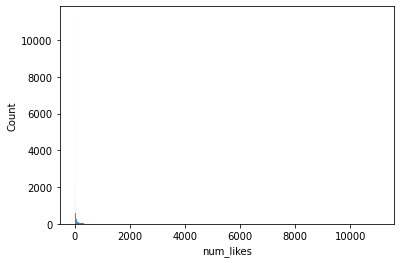

In [3]:
sns.histplot(data=reviews["num_likes"])

Very skewed

In [ ]:
reviews[["num_likes", "star_rating"]].describe()

,num_likes,star_rating
count,75682.000000,73268.000000
mean,52.982175,3.802670
std,181.236763,1.321667
min,0.000000,1.000000
25%,2.000000,3.000000
50%,8.000000,4.000000
75%,37.000000,5.000000
max,11048.000000,5.000000


In [ ]:
sum(reviews["num_likes"].astype("int") == 0)/sum(reviews["num_likes"])

0.0022198131227092045

Doesn't say "x out of y people liked this", it says "x people liked this".  
Use total likes on first page of book reviews as y.

In [ ]:
total_likes_per_book = reviews[["book_title", "num_likes"]].groupby("book_title").agg(np.sum).sort_values("num_likes", ascending=False)
total_likes_per_book.head()

,num_likes
book_title,
A Little Life,32672
Six of Crows,29614
A Court of Mist and Fury,28881
The Song of Achilles,27397
Harry Potter and the Sorcerer's Stone,26890


In [ ]:
list(total_likes_per_book.index).index("Six of Crows")

1

In [ ]:
def get_prop_total_likes(book_title, num_likes):
  index_of_book = list(total_likes_per_book.index).index(book_title)
  total_of_book = total_likes_per_book.iloc[index_of_book]
  return num_likes/total_of_book

In [ ]:
reviews["prop_total_likes"] = reviews[["book_title", "num_likes"]].apply(lambda x: get_prop_total_likes(x["book_title"], int(x["num_likes"])), axis=1)
reviews["prop_total_likes"].sample(5)

71739    0.007092
5711     0.000000
57284    0.052941
52144    0.394737
1334     0.014706
Name: prop_total_likes, dtype: float64

In [ ]:
reviews["prop_total_likes"].describe()

count    75486.000000
mean         0.035464
std          0.061804
min          0.000000
25%          0.010417
50%          0.017966
75%          0.035199
max          1.000000
Name: prop_total_likes, dtype: float64

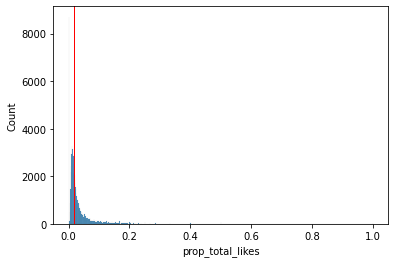

In [ ]:
sns.histplot(data=reviews["prop_total_likes"]).axvline(x=0.017966, color='r', linestyle='-', linewidth=1)

I'm gonna call it at the median.

In [ ]:
threshold = 0.017966

In [ ]:
sum(reviews["helpful"].isna()), sum(reviews["num_likes"].isna()), sum(reviews["prop_total_likes"].isna())

(0, 0, 0)

In [ ]:
reviews = reviews[~reviews["helpful"].isna()]
sum(reviews["helpful"].isna())

0

In [ ]:
reviews = reviews[~reviews["prop_total_likes"].isna()]
sum(reviews["prop_total_likes"].isna())

0

In [ ]:
reviews["helpful"] = reviews["prop_total_likes"].apply(lambda x: 0 if x < threshold else 1)
reviews["helpful"].sample(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


4007     0
2874     0
32509    0
417      1
8665     1
Name: helpful, dtype: int64

In [ ]:
reviews.to_csv("reviews_labeled.csv", header=True, index=False)


***
# Language Modelling  
Sources: 
- https://course.fast.ai/videos/?lesson=8
- https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb

## Default tokenization rules

defaults.text_spec_tok = [UNK, PAD, BOS, EOS, FLD, TK_REP, TK_WREP, TK_UP, TK_MAJ]  
defaults.text_proc_rules = [fix_html, replace_rep, replace_wrep, spec_add_spaces, rm_useless_spaces,
                            replace_all_caps, replace_maj, lowercase]  
defaults.text_postproc_rules = [replace_space]  

## DataBlock for fine tuning the language model

In [17]:
datablock_lm = DataBlock(
    blocks=TextBlock.from_df('review_text', is_lm=True),
    get_items=ColReader('review_text'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

In [18]:
dls_lm = datablock_lm.dataloaders(reviews, bs=128, seq_len=72, shuffle=True)

In [ ]:
dls_lm.show_batch(max_n=3)

,text,text_
0,"xxbos i was so looking forward to getting my hands on the last of xxmaj the xxmaj dragon xxmaj knight 's and reading xxmaj adam ’s and xxmaj margaret ’s story . xxmaj as readers of the series will know , the series starts with xxmaj margaret 's death , but what xxmaj adam thought was the end of their love , was in fact , only the beginning . i am","i was so looking forward to getting my hands on the last of xxmaj the xxmaj dragon xxmaj knight 's and reading xxmaj adam ’s and xxmaj margaret ’s story . xxmaj as readers of the series will know , the series starts with xxmaj margaret 's death , but what xxmaj adam thought was the end of their love , was in fact , only the beginning . i am pleased"
1,"their cries of “ amen ! ” and “ hallelujah ! ” and “ yes , xxmaj lord ’ ” and “ praise xxmaj his name ! ” and “ preach it , brother ! ” sustained and whipped on my solos until we all became equal , wringing wet , singing and dancing , in anguish and rejoicing , at the foot of the altar . xxmaj it was ,","cries of “ amen ! ” and “ hallelujah ! ” and “ yes , xxmaj lord ’ ” and “ praise xxmaj his name ! ” and “ preach it , brother ! ” sustained and whipped on my solos until we all became equal , wringing wet , singing and dancing , in anguish and rejoicing , at the foot of the altar . xxmaj it was , for"
2,"american . xxmaj through her love life we see xxmaj ifemelu ’s own conflicting feelings regarding race in xxmaj america . xxmaj she begins to read voraciously and joins the xxmaj african xxmaj students xxmaj association . xxmaj she educates herself . xxmaj why must it be the newcomer that does all the legwork for us ? xxmaj should n’t we all be doing these things – here , right now ?",". xxmaj through her love life we see xxmaj ifemelu ’s own conflicting feelings regarding race in xxmaj america . xxmaj she begins to read voraciously and joins the xxmaj african xxmaj students xxmaj association . xxmaj she educates herself . xxmaj why must it be the newcomer that does all the legwork for us ? xxmaj should n’t we all be doing these things – here , right now ? “"


## Fine tuning the language model

### Create Learner

In [ ]:
learner_lm = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy]).to_fp16()

### Fit one cycle

In [ ]:
learner_lm.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.145433,4.023398,0.280155,39:18


In [ ]:
learner_lm.save('1epoch')

Path('models/1epoch.pth')

In [ ]:
# learner_lm = learner_lm.load('1epoch')

### Unfreeze and train more

In [ ]:
learner_lm.unfreeze()

In [ ]:
for epoch in range(2,7):
  print(f"Starting epoch {epoch}")
  learner_lm.fit_one_cycle(1, 2e-3)

  learner_lm.save(f'{epoch}epoch')


Starting epoch 2


epoch,train_loss,valid_loss,accuracy,time
0,3.814817,3.840313,0.301802,39:38


Starting epoch 3


epoch,train_loss,valid_loss,accuracy,time
0,3.724114,3.800474,0.306706,40:59


Starting epoch 4


epoch,train_loss,valid_loss,accuracy,time
0,3.658504,3.782737,0.308836,39:59


Starting epoch 5


epoch,train_loss,valid_loss,accuracy,time
0,3.593365,3.773896,0.310353,39:26


Starting epoch 6


epoch,train_loss,valid_loss,accuracy,time
0,3.542236,3.772575,0.311065,39:34


## Save the encoder (all but output layer)

In [ ]:
learner_lm.save_encoder('finetuned')

# What is helpful? Contiued

In [ ]:
# make confusion matrix

In [2]:
np.median(reviews["prop_total_likes"])

0.018404907975460124

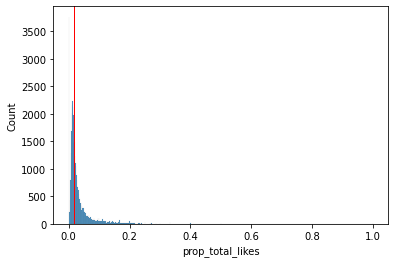

In [6]:
sns.histplot(data=reviews["prop_total_likes"]).axvline(x=np.median(reviews["prop_total_likes"]),
                                                       color='r', linestyle='-', linewidth=1)

Separate the classes more

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


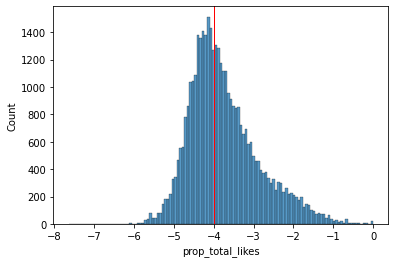

In [4]:
sns.histplot(data=np.log(reviews["prop_total_likes"])).axvline(x=np.median(np.log(reviews["prop_total_likes"])),
                                                               color='r', linestyle='-', linewidth=1)

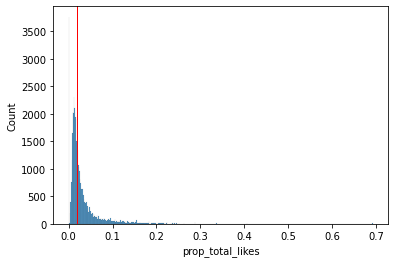

In [23]:
sns.histplot(data=np.log1p(reviews["prop_total_likes"])).axvline(x=np.median(np.log1p(reviews["prop_total_likes"])),
                                                               color='r', linestyle='-', linewidth=1)

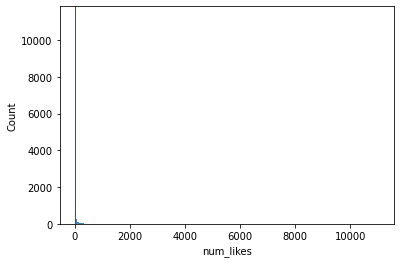

In [5]:
sns.histplot(data=reviews["num_likes"]).axvline(x=np.median(reviews["num_likes"]),
                                                               color='r', linestyle='-', linewidth=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


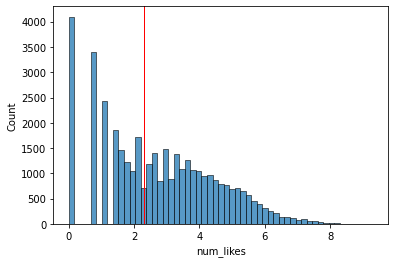

In [6]:
sns.histplot(data=np.log(reviews["num_likes"])).axvline(x=np.median(np.log(reviews["num_likes"])),
                                                               color='r', linestyle='-', linewidth=1)

# Improve the classes
1. transform on *prop_total_likes*
2. discretize into bins
  - histogram
    - 10
  - clustering
    - find best # clusters with silhouette metric
  - quantile 
    - 2
    - 4

## Transform into a better distribution

In [7]:
reviews["prop_total_likes"].describe()

count    42747.000000
mean         0.035104
std          0.057736
min          0.000000
25%          0.011152
50%          0.018405
75%          0.034927
max          1.000000
Name: prop_total_likes, dtype: float64

In [8]:
# transform with sqrt. cant do log or boxcox because there are zero values
prop_total_likes_transformed = np.sqrt(reviews["prop_total_likes"])

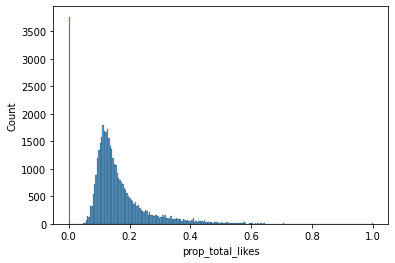

In [9]:
sns.histplot(data=prop_total_likes_transformed)

# .axvline(x=np.median(prop_total_likes_transformed), color='r', linestyle='-', linewidth=1)

## Calculate the different binnings

In [131]:
# histogram equal width binning
histogram_edges = np.histogram_bin_edges(prop_total_likes_transformed, bins=10)
histogram_edges

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [132]:
# match each interval with a quantile
from scipy.stats.mstats import mquantiles
# adapted from find_quantiles below
def find_histogram(arr, histogram_edges):
  q_values = histogram_edges
  num_quantiles = len(histogram_edges)-1

  q_labels = [0]*len(arr)

  q_values_rev = np.flip(q_values)[1:] #take off 1.0

  for index1, q_cutoff in enumerate(q_values_rev):
    this_q_label = num_quantiles-index1
    for index2, val in enumerate(arr):
      if val >= q_cutoff and q_labels[index2] == 0:
        # index of arr and q_labels match up
        # set q_labels[index] to this_q_label if q_labels[index] hasnt been set yet (==0)
        q_labels[index2] = this_q_label 

  return q_labels

In [135]:
histogram_bins = find_histogram(prop_total_likes_transformed, histogram_edges)
np.unique(np.array(histogram_bins))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [13]:
# clustering
'''
"Reshape your data either using array.reshape(-1, 1) if "
"your data has a single feature or array.reshape(1, -1) "
"if it contains a single sample."
'''
prop_likes_cluster = prop_total_likes_transformed.to_numpy().reshape(-1,1)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []

for num_clusters in range(2,11):
  kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(prop_likes_cluster)
  scores.append(silhouette_score(prop_likes_cluster, kmeans.labels_))

# higher is better
# index 0 corresponds to 2 clusters
best_k = scores.index(max(scores)) + 2
best_k

2

In [35]:
# get bins clustering
from sklearn.cluster import KMeans
prop_total_likes_transformed = np.sqrt(reviews["prop_total_likes"])
prop_likes_cluster = prop_total_likes_transformed.to_numpy().reshape(-1,1)
best_k=2
kmeans_best = KMeans(n_clusters=best_k, random_state=42).fit(prop_likes_cluster)
cluster_bins = kmeans_best.labels_
cluster_bins

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [104]:
# match each value with a quantile

from scipy.stats.mstats import mquantiles
def find_quantiles(arr, num_quantiles):
  probs = np.linspace(0, 1, num=num_quantiles+1)
  q_values = mquantiles(arr, prob=probs)

  q_labels = [0]*len(arr)

  q_values_rev = np.flip(q_values)[1:] #take off 1.0

  for index1, q_cutoff in enumerate(q_values_rev):
    this_q_label = num_quantiles-index1
    for index2, val in enumerate(arr):
      if val >= q_cutoff and q_labels[index2] == 0:
        # index of arr and q_labels match up
        # set q_labels[index] to this_q_label if q_labels[index] hasnt been set yet (==0)
        q_labels[index2] = this_q_label 

  return q_labels

In [117]:
# quantile binnings
q2_bins = find_quantiles(prop_total_likes_transformed, 2)
q4_bins = find_quantiles(prop_total_likes_transformed, 4)

In [99]:
reviews.columns

Index(['book_title', 'review_text', 'num_likes', 'star_rating', 'pred_lang',
       'pred_conf', 'prop_total_likes', 'helpful'],
      dtype='object')

In [146]:
data_mat = reviews[["review_text", "prop_total_likes", "helpful"]]
data_mat["10_histogram_bins"] = histogram_bins
data_mat["2_cluster_bins"] = cluster_bins
data_mat["2_quantile_bins"] = two_q_bins
data_mat["4_quantile_bins"] = four_q_bins

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [147]:
data_mat.columns

Index(['review_text', 'prop_total_likes', 'helpful', '10_histogram_bins',
       '2_cluster_bins', '2_quantile_bins', '4_quantile_bins'],
      dtype='object')

In [148]:
data_mat.to_csv("2nd_attempt_data_and_labels", header=True)

In [171]:
prop_total_likes_transformed = np.sqrt(data_mat["prop_total_likes"])

## Plot bin edges

In [37]:
# plot with boundary lines
import matplotlib.transforms as mt
def plot_with_boundary_lines(boundaries):
  fig, ax = plt.subplots()
  sns.histplot(data=prop_total_likes_transformed, ax=ax)

  transform = mt.blended_transform_factory(ax.transData, ax.transAxes)
  ax.vlines(x=boundaries, ymin=0, ymax = max(prop_total_likes_transformed), linewidth=1, color='r', linestyle='-', transform=transform)

  plt.show()

#### Histogram binning

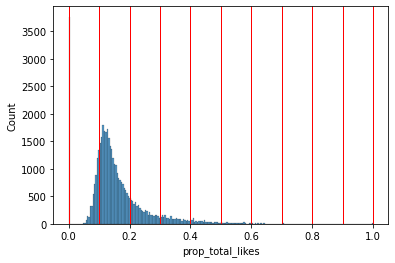

In [141]:
# histogram
plot_with_boundary_lines(histogram_edges)

#### Cluster binning

In [145]:
# gotta find boundaries of clusters
cluster_bins

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [150]:
sort_by_tuples = [(value, cluster_bins[index]) for index, value in enumerate(prop_total_likes_transformed)]

In [152]:
sort_by_tuples.sort(key=lambda x: x[0])

In [164]:
find_switch = [x[1] for x in sort_by_tuples]

In [165]:
find_switch.index(1)

36370

In [167]:
sort_by_tuples[36369]

(0.23375024119288512, 0)

In [166]:
sort_by_tuples[36370]

(0.23383880667381962, 1)

In [36]:
cluster_edges = np.array([0.0, 0.23383880667381962, 1.0])

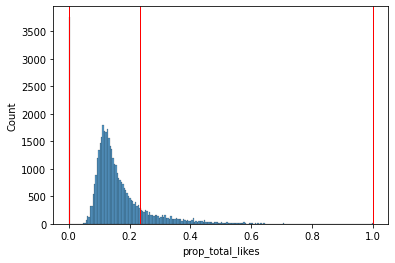

In [38]:
plot_with_boundary_lines(cluster_edges)

#### Quantile binning

In [119]:
# quantiles
q2_edges = mquantiles(prop_total_likes_transformed, prob=np.linspace(0, 1, num=2+1))
q4_edges = mquantiles(prop_total_likes_transformed, prob=np.linspace(0, 1, num=4+1))

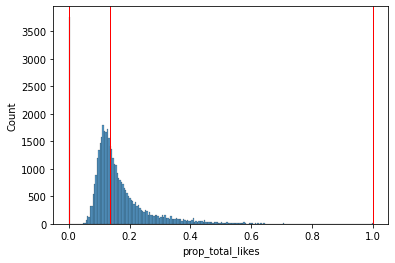

In [120]:
plot_with_boundary_lines(q2_edges)

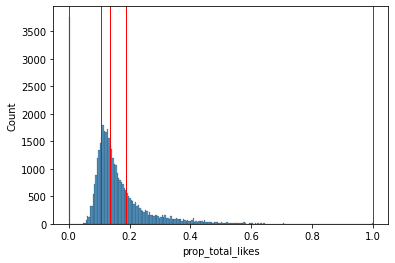

In [121]:
plot_with_boundary_lines(q4_edges)

# Modelling with different discretizations

## Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/
!pip install -U fastai
from fastai.text.all import *
import pandas as pd
import seaborn as sns
%matplotlib inline

data_mat = pd.read_csv("2nd_attempt_data_and_labels.csv")
reviews = pd.read_csv("reviews_labeled.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/'
/content/drive/MyDrive


In [3]:
datablock_lm = DataBlock(
    blocks=TextBlock.from_df('review_text', is_lm=True),
    get_items=ColReader('review_text'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

dls_lm = datablock_lm.dataloaders(data_mat, bs=128, seq_len=72, shuffle=True)

## Original method (median of prop_total_likes)

In [4]:
helpfulness_clas_orig = DataBlock(
    blocks=(TextBlock.from_df('review_text', vocab=dls_lm.vocab, is_lm=False), CategoryBlock),
    get_x=ColReader('text'), 
    get_y=ColReader('helpful'), 
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

dls_clas_orig = helpfulness_clas_orig.dataloaders(data_mat, bs=128, seq_len=72, shuffle=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [5]:
dls_clas_orig.vocab = dls_lm.vocab
learn_clas_orig = text_classifier_learner(dls_clas_orig, 
                                     AWD_LSTM, 
                                     drop_mult=0.5, 
                                     metrics=[accuracy, Precision(), Recall()]).to_fp16()

In [180]:
learn_clas_orig = learn_clas_orig.load_encoder('finetuned')

SuggestedLRs(valley=0.015848932787775993)

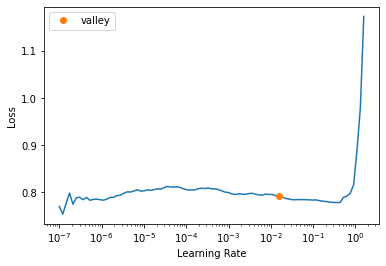

In [181]:
# middle of the steepest downward slope from lr find
learn_clas_orig.lr_find()

In [182]:
learn_clas_orig.fit_one_cycle(1, 0.015848932787775993)
learn_clas_orig.freeze_to(-2)
# lr find?
learn_clas_orig.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))
learn_clas_orig.freeze_to(-3)
# lr find?
learn_clas_orig.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))
learn_clas_orig.unfreeze()
# lr find?
learn_clas_orig.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))
learn_clas_orig.save('5epoch_clf_orig')

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.687565,0.680536,0.557375,0.564140,0.619977,02:11


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.685712,0.675996,0.576676,0.584154,0.619296,02:28


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.680463,0.673911,0.579483,0.585156,0.631782,03:26


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.657022,0.682155,0.573166,0.586897,0.579569,04:12
1,0.644404,0.690169,0.573868,0.576018,0.655392,04:14


Path('models/5epoch_clf_orig.pth')

In [183]:
learn_clas_orig.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.639785,0.693345,0.575506,0.587624,0.590692,04:15
1,0.630118,0.703733,0.566967,0.581649,0.568445,04:16
2,0.620424,0.719826,0.574336,0.598966,0.526220,04:14
3,0.585741,0.731113,0.576091,0.576047,0.671510,04:13
4,0.574357,0.744822,0.571178,0.596099,0.520318,04:14


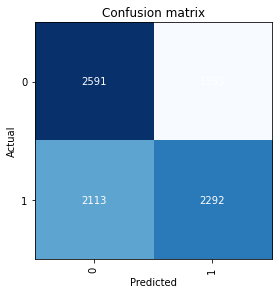

In [191]:
orig_interp = ClassificationInterpretation.from_learner(learn_clas_orig)
orig_interp.plot_confusion_matrix()

## Histogram bins

In [6]:
helpfulness_clas_hist = DataBlock(
    blocks=(TextBlock.from_df('review_text', vocab=dls_lm.vocab, is_lm=False), CategoryBlock),
    get_x=ColReader('text'), 
    get_y=ColReader('10_histogram_bins'), 
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

dls_clas_hist = helpfulness_clas_hist.dataloaders(data_mat, bs=128, seq_len=72, shuffle=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [7]:
dls_clas_hist.vocab = dls_lm.vocab
learn_clas_hist = text_classifier_learner(dls_clas_hist, 
                                     AWD_LSTM, 
                                     drop_mult=0.5, 
                                     metrics=[accuracy]).to_fp16()

In [207]:
learn_clas_hist = learn_clas_hist.load_encoder('finetuned')

SuggestedLRs(valley=0.004365158267319202)

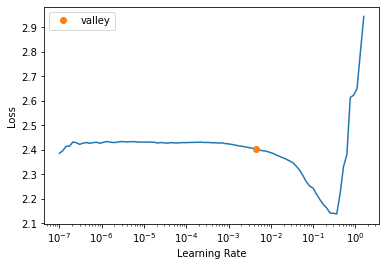

In [208]:
learn_clas_hist.lr_find()

In [209]:
# lr find?
learn_clas_hist.fit_one_cycle(1, 0.009120108559727669)
learn_clas_hist.freeze_to(-2)
# lr find?
learn_clas_hist.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))
learn_clas_hist.freeze_to(-3)
# lr find?
learn_clas_hist.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))
learn_clas_hist.unfreeze()
# lr find?
learn_clas_hist.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))
learn_clas_hist.save('5epoch_clf_hist')

epoch,train_loss,valid_loss,accuracy,time
0,1.198438,1.173772,0.578664,02:12


epoch,train_loss,valid_loss,accuracy,time
0,1.189344,1.171944,0.580302,02:27


epoch,train_loss,valid_loss,accuracy,time
0,1.173048,1.167234,0.578430,03:27


epoch,train_loss,valid_loss,accuracy,time
0,1.131105,1.161424,0.582875,04:17
1,1.114578,1.165725,0.580653,04:18


Path('models/5epoch_clf_hist.pth')

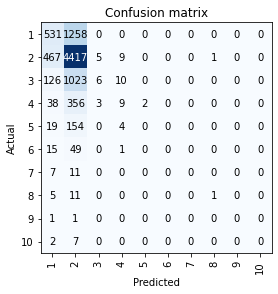

In [210]:
hist_interp = ClassificationInterpretation.from_learner(learn_clas_hist)
hist_interp.plot_confusion_matrix()

## KMeans Clustering bins

In [8]:
data_mat["2_cluster_bins"] = data_mat["2_cluster_bins"].apply(lambda x: "1" if x ==1 else "0")

In [9]:
helpfulness_clas_clust = DataBlock(
    blocks=(TextBlock.from_df('review_text', vocab=dls_lm.vocab, is_lm=False), CategoryBlock),
    get_x=ColReader('text'), 
    get_y=ColReader('2_cluster_bins'), 
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

dls_clas_clust = helpfulness_clas_clust.dataloaders(data_mat, bs=128, seq_len=72, shuffle=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [10]:
dls_clas_clust.vocab = dls_lm.vocab
learn_clas_clust = text_classifier_learner(dls_clas_clust, 
                                     AWD_LSTM, 
                                     drop_mult=0.5, 
                                     metrics=[accuracy, Precision(), Recall()]).to_fp16()

In [240]:
learn_clas_clust = learn_clas_clust.load_encoder('finetuned')

SuggestedLRs(valley=0.033113110810518265)

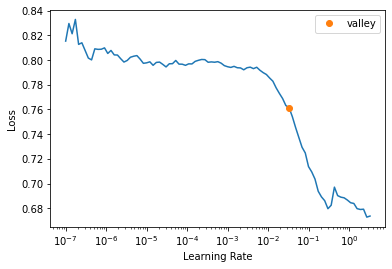

In [241]:
learn_clas_clust.lr_find()

In [242]:
# lr find?
learn_clas_clust.fit_one_cycle(1, 0.033113110810518265)
learn_clas_clust.freeze_to(-2)
# lr find?
learn_clas_clust.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))
learn_clas_clust.freeze_to(-3)
# lr find?
learn_clas_clust.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))
learn_clas_clust.unfreeze()
# lr find?
learn_clas_clust.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))
learn_clas_clust.save('5epoch_clf_clust')

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.425549,0.420887,0.850275,0.000000,0.000000,02:09


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.418212,0.416288,0.851094,0.612903,0.014844,02:27


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.417205,0.416052,0.850158,0.489796,0.018750,03:25


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.397769,0.418365,0.850743,0.541667,0.020313,04:15
1,0.401506,0.420641,0.851094,0.566038,0.023438,04:15


Path('models/5epoch_clf_clust.pth')

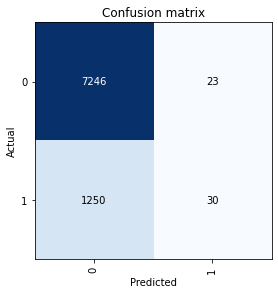

In [243]:
clust_interp = ClassificationInterpretation.from_learner(learn_clas_clust)
clust_interp.plot_confusion_matrix()

highly imbalanced

## 2 Quantiles bins

In [11]:
helpfulness_clas_2q = DataBlock(
    blocks=(TextBlock.from_df('review_text', vocab=dls_lm.vocab, is_lm=False), CategoryBlock),
    get_x=ColReader('text'), 
    get_y=ColReader('2_quantile_bins'), 
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

dls_clas_2q = helpfulness_clas_2q.dataloaders(data_mat, bs=128, seq_len=72, shuffle=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [12]:
dls_clas_2q.vocab = dls_lm.vocab
learn_clas_2q = text_classifier_learner(dls_clas_2q, 
                                     AWD_LSTM, 
                                     drop_mult=0.5, 
                                     metrics=[accuracy, Precision(), Recall()]).to_fp16()

In [246]:
learn_clas_2q = learn_clas_2q.load_encoder('finetuned')

SuggestedLRs(valley=0.033113110810518265)

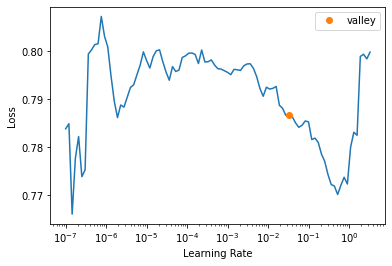

In [247]:
learn_clas_2q.lr_find()

In [249]:
# lr find?
learn_clas_2q.fit_one_cycle(1, 0.033113110810518265)
learn_clas_2q.freeze_to(-2)
# lr find?
learn_clas_2q.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))
learn_clas_2q.freeze_to(-3)
# lr find?
learn_clas_2q.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))
learn_clas_2q.unfreeze()
# lr find?
learn_clas_2q.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))
learn_clas_2q.save('5epoch_clf_2q')

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.688718,1.382836,0.540765,0.528546,0.832638,02:27


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.683186,0.797783,0.563926,0.564737,0.592490,02:27


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.682638,0.831353,0.556907,0.544927,0.739453,03:26


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.675251,1.393646,0.569657,0.570634,0.594576,04:15
1,0.672760,1.349901,0.576325,0.581565,0.571859,04:15


Path('models/5epoch_clf_2q.pth')

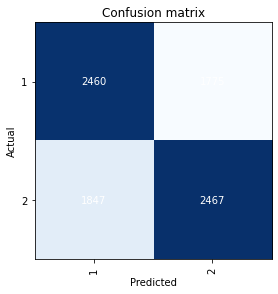

In [250]:
q2_interp = ClassificationInterpretation.from_learner(learn_clas_2q)
q2_interp.plot_confusion_matrix()

## 4 Quantiles bins

In [13]:
helpfulness_clas_4q = DataBlock(
    blocks=(TextBlock.from_df('review_text', vocab=dls_lm.vocab, is_lm=False), CategoryBlock),
    get_x=ColReader('text'), 
    get_y=ColReader('4_quantile_bins'), 
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

dls_clas_4q = helpfulness_clas_4q.dataloaders(data_mat, bs=128, seq_len=72, shuffle=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [14]:
dls_clas_4q.vocab = dls_lm.vocab
learn_clas_4q = text_classifier_learner(dls_clas_4q, 
                                     AWD_LSTM, 
                                     drop_mult=0.5, 
                                     metrics=[accuracy]).to_fp16()

In [253]:
learn_clas_4q = learn_clas_4q.load_encoder('finetuned')

SuggestedLRs(valley=0.05754399299621582)

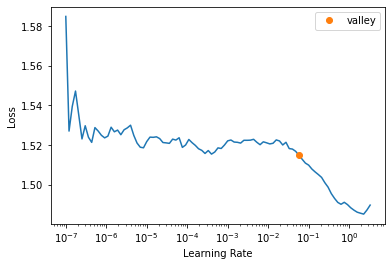

In [254]:
learn_clas_4q.lr_find()

In [256]:
# lr find?
learn_clas_4q.fit_one_cycle(1, 0.05754399299621582)
learn_clas_4q.freeze_to(-2)
# lr find?
learn_clas_4q.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))
learn_clas_4q.freeze_to(-3)
# lr find?
learn_clas_4q.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))
learn_clas_4q.unfreeze()
# lr find?
learn_clas_4q.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))
learn_clas_4q.save('5epoch_clf_4q')

epoch,train_loss,valid_loss,accuracy,time
0,1.375119,4.200716,0.283542,02:28


epoch,train_loss,valid_loss,accuracy,time
0,1.366328,5.589562,0.293368,02:26


epoch,train_loss,valid_loss,accuracy,time
0,1.360971,1.790421,0.308340,03:26


epoch,train_loss,valid_loss,accuracy,time
0,1.352823,1.773824,0.305533,04:15
1,1.352416,12.353682,0.309744,04:13


Path('models/5epoch_clf_4q.pth')

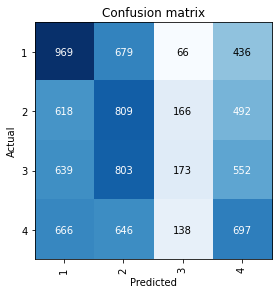

In [257]:
q4_interp = ClassificationInterpretation.from_learner(learn_clas_4q)
q4_interp.plot_confusion_matrix()

# Finding statistics for reports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/
!pip install -U fastai
from fastai.text.all import *
import pandas as pd
import seaborn as sns
%matplotlib inline

books = pd.read_csv("books.csv", index_col=0)
reviews = pd.read_csv("reviews_labeled.csv")
data_mat = pd.read_csv("2nd_attempt_data_and_labels.csv", index_col=0)

In [20]:
books.columns, books.shape

(Index(['book_title', 'author', 'url', 'avg_rating', 'num_ratings',
        'num_reviews'],
       dtype='object'), (2746, 6))

In [21]:
reviews.columns, reviews.shape

(Index(['book_title', 'review_text', 'num_likes', 'star_rating', 'pred_lang',
        'pred_conf', 'prop_total_likes', 'helpful'],
       dtype='object'), (42747, 8))

In [22]:
data_mat.columns, data_mat.shape

(Index(['review_text', 'prop_total_likes', 'helpful', '10_histogram_bins',
        '2_cluster_bins', '2_quantile_bins', '4_quantile_bins'],
       dtype='object'), (42747, 7))

In [15]:
learn_clas_2q = learn_clas_2q.load("5epoch_clf_2q")
learn_clas_4q = learn_clas_4q.load("5epoch_clf_4q")
learn_clas_clust = learn_clas_clust.load("5epoch_clf_clust")
learn_clas_hist = learn_clas_hist.load("5epoch_clf_hist")
learn_clas_orig = learn_clas_orig.load("5epoch_clf_orig")

In [16]:
q2_interp = ClassificationInterpretation.from_learner(learn_clas_2q)
q4_interp = ClassificationInterpretation.from_learner(learn_clas_4q)
clust_interp = ClassificationInterpretation.from_learner(learn_clas_clust)
hist_interp = ClassificationInterpretation.from_learner(learn_clas_hist)
orig_interp = ClassificationInterpretation.from_learner(learn_clas_orig)

In [21]:
% pip install disarray

In [24]:
import disarray

In [18]:
# get confusion matrices and turn them into pandas dataframes
q2_cm = pd.DataFrame(q2_interp.confusion_matrix())
q4_cm = pd.DataFrame(q4_interp.confusion_matrix())
clust_cm = pd.DataFrame(clust_interp.confusion_matrix())
hist_cm = pd.DataFrame(hist_interp.confusion_matrix())
orig_cm = pd.DataFrame(orig_interp.confusion_matrix())

In [30]:
q2_cm.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'f1'])

,0,1,micro-average
accuracy,0.478068,0.478068,0.478068
precision,0.422737,0.489548,0.478068
recall,0.146635,0.803431,0.478068
f1,0.217742,0.608390,0.478068


In [31]:
q4_cm.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'f1'])

,0,1,2,3,micro-average
accuracy,0.722190,0.755995,0.386010,0.606738,0.617733
precision,0.121212,0.333333,0.245542,0.222982,0.235466
recall,0.016744,0.000480,0.686202,0.227760,0.235466
f1,0.029424,0.000958,0.361668,0.225346,0.235466


In [32]:
clust_cm.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'f1'])

,0,1,micro-average
accuracy,0.211487,0.211487,0.211487
precision,0.864641,0.151054,0.211487
recall,0.086119,0.923438,0.211487
f1,0.156637,0.259638,0.211487


In [33]:
hist_cm.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'f1'])

,0,1,2,3,4,5,6,7,8,9,micro-average
accuracy,0.773307,0.607907,0.863493,0.950521,0.979062,0.992397,0.997894,0.998011,0.999766,0.998947,0.916131
precision,0.438481,0.606148,0.428571,0.272727,0.000000,NaN,NaN,0.500000,NaN,NaN,0.580653
recall,0.296814,0.901613,0.005150,0.022059,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.580653
f1,0.354000,0.724930,0.010178,0.040816,NaN,NaN,NaN,0.105263,NaN,NaN,0.580653


In [34]:
orig_cm.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'f1'])

,0,1,micro-average
accuracy,0.573868,0.573868,0.573868
precision,0.570823,0.576018,0.573868
recall,0.487210,0.655392,0.573868
f1,0.525713,0.613146,0.573868
